In [3]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
import blimpy as bl
import setigen as stg

In [24]:
def NB_inject(ip_file_stem, SNR,drift_rate, num_branches,f_start,f_stop,num_signals,op_file_stem ):
    
    start_chan = 0
    raw_params = stg.voltage.get_raw_params(input_file_stem=ip_file_stem, start_chan=start_chan)
    sample_rate=raw_params['chan_bw']*num_branches # chan_bw = sample_rate / num_branches to keep this constant 
    num_taps=8
    

    print('\n input file parameters: \n ',raw_params)
    
    antenna = stg.voltage.Antenna(sample_rate=sample_rate, **raw_params)
    
    

    filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                                 num_branches=num_branches)

    rvb = stg.voltage.RawVoltageBackend.from_data(input_file_stem=ip_file_stem,
                                                  antenna_source=antenna,
                                                  filterbank=filterbank,
                                                  start_chan=start_chan,
                                                  num_subblocks=128)

#     v = antenna.x.get_samples(100000)

#     plt.figure(figsize=(10, 5))
#     plt.plot(get_numpy(v))
#     plt.xlabel('Sample')
#     plt.ylabel('V')
#     plt.show()
#     std=cp.std(v)
#     print('ST. Dev', std)
    
    assert f_start> rvb.fch1 and f_stop< rvb.fch1+rvb.chan_bw*rvb.num_chans, 'injection frequencies out of range '

#     print('\n Antenna noise std',antenna.x.get_total_noise_std())

    fftlength = 1024
    nb=2#stg.voltage.get_total_blocks(ip_file_stem)
    
    print('\n total blocks in the file', nb)
    
    signal_level = stg.voltage.get_level(snr=SNR,
                                raw_voltage_backend=rvb,
                                fftlength=fftlength,
    #                             obs_length=4.652881237333333,
    #                             length_mode='obs_length'
                                num_blocks=nb,
                                length_mode='num_blocks'
                                        )

    print('\nsignal level ', signal_level)
    


    for fstart in np.linspace(f_start, f_stop, num_signals):
        leakage_factor = stg.voltage.get_leakage_factor(fstart, rvb, fftlength)
        print(f'{fstart/1e6:.4f} MHz leakage factor: {leakage_factor:.3f}')

        for stream in antenna.streams:
            # There's actually no noise present, but we set levels assuming a background noise_std of 1
            level = 1 * leakage_factor * signal_level
            print('level: ',level)
            stream.add_constant_signal(f_start=fstart, 
                                       drift_rate=drift_rate*u.Hz/u.s, 
                                       level=level)
    
    print('unit drift rate corres. 1x1 pixel in final data',stg.voltage.get_unit_drift_rate(rvb, fftlength, 1))
            
    rvb.record(output_file_stem=op_file_stem,
               num_blocks=nb, 
               length_mode='num_blocks',
              header_dict={'TELESCOP': 'GMRT', 'OBSERVER': 'AE' , 'SRC_NAME' : '7202'},
               digitize=False ,
               verbose=False)


    #header info for the new file with signal 


    header_info = stg.voltage.get_raw_params(input_file_stem=op_file_stem)


#     print('\n header of new file\n',header_info)

#     cmd='rawspec -f 1024 -t 1 -d ./data/trial '+op_file_stem
#     os.system(cmd)
    
#     cmd_h5='rawspec -j -f 8192 -t 1  -d ./data/573_100 '+op_file_stem
#     os.system(cmd_h5)


In [25]:
# ip_file_stem='/home/eakshay/amity/raghav/GSB_iFFT_pipeline/PASV_to_GUPPI/TEST_padding_v2_guppi'
ip_file_stem='/datax/scratch/AMITY_INDIA/eakshay/setigen/data/trial/Noise'
SNR=100
drift_rate=0
# drift_rate=2.220446049250313
num_branches=1024
f_start= 562e6
f_stop=563e6
num_signals=5
op_file_stem='/home/eakshay/ea/setigen/data/trial/t1'

NB_inject(ip_file_stem, SNR, drift_rate, num_branches,f_start,f_stop,num_signals,op_file_stem )



 input file parameters: 
  {'num_bits': 8, 'chan_bw': 1000000.0, 'ascending': True, 'num_pols': 1, 'block_size': 134217728, 'obs_length': 2.097152, 'tbin': 1e-06, 'num_antennas': 1, 'num_chans': 64, 'center_freq': 531500000.0, 'fch1': 500000000.0}

 total blocks in the file 2

signal level  0.0029033376831121118
562.0000 MHz leakage factor: 1.000
level:  0.0029033376831121118
562.2500 MHz leakage factor: 1.000
level:  0.0029033376831121118
562.5000 MHz leakage factor: 1.000
level:  0.0029033376831121118
562.7500 MHz leakage factor: 1.000
level:  0.0029033376831121118
563.0000 MHz leakage factor: 1.000
level:  0.0029033376831121118
unit drift rate corres. 1x1 pixel in final data 953674.31640625


Blocks: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:21<00:00, 10.80s/it]


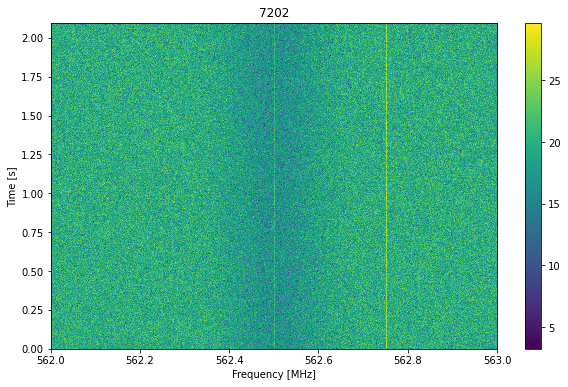

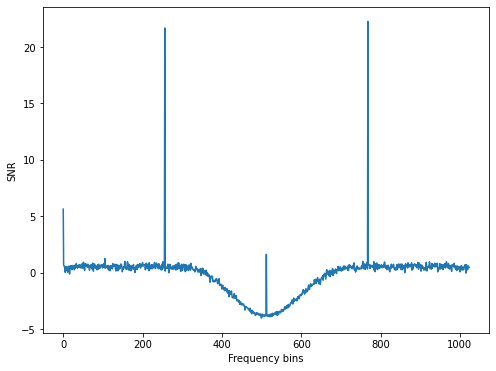

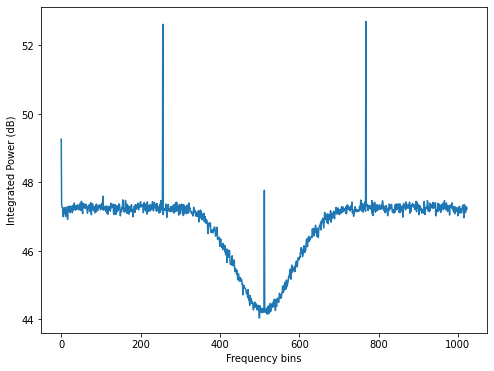

In [26]:
%matplotlib inline 

loc=op_file_stem+'.rawspec.0000.fil'
wf = bl.Waterfall(loc,
                  f_start=f_start/1e6,
                  f_stop=f_stop/1e6)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

#SNR plot

frame = stg.Frame(wf)

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

#data in db 

x = stg.db(np.sum(wf.data[:, 0, :], axis=0))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()

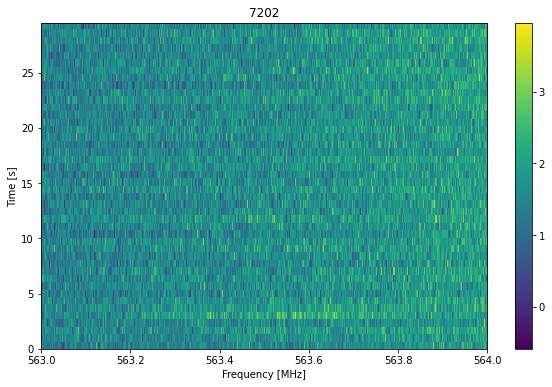

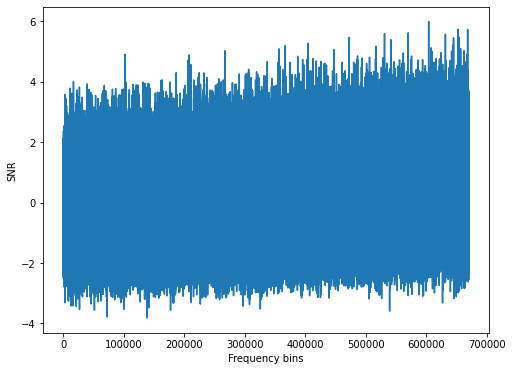

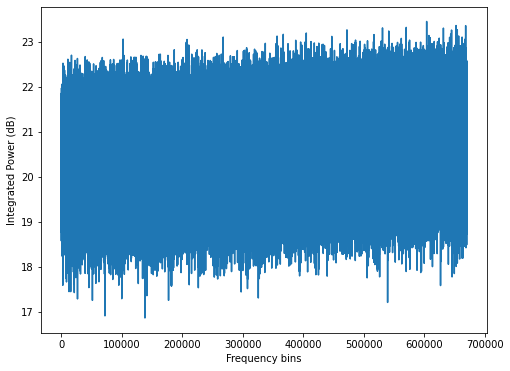

In [13]:
%matplotlib inline 

# loc=op_file_stem+'.rawspec.0000.fil'
wf = bl.Waterfall('/home/eakshay/ea/setigen/data/573_50/inj_573_50_dig_False.rawspec.0000.fil',
                  f_start=f_start/1e6,
                  f_stop=f_stop/1e6)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

#SNR plot

frame = stg.Frame(wf)

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

#data in db 

x = stg.db(np.sum(wf.data[:, 0, :], axis=0))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()

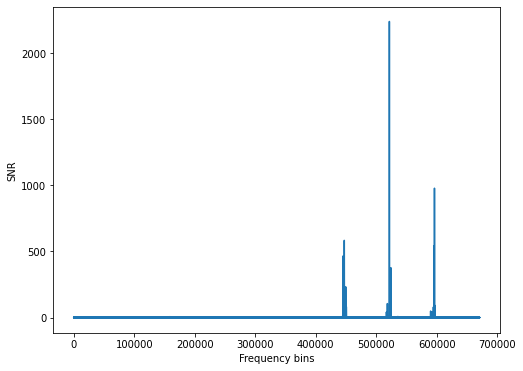

In [13]:
%matplotlib inline 

loc=op_file_stem+'.rawspec.0000.fil'
wf = bl.Waterfall(loc,
                  f_start=f_start/1e6,
                  f_stop=f_stop/1e6)

# plt.figure(figsize=(10, 6))
# wf.plot_waterfall()
# plt.show()

#SNR plot

frame = stg.Frame(wf)

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

# into .fil

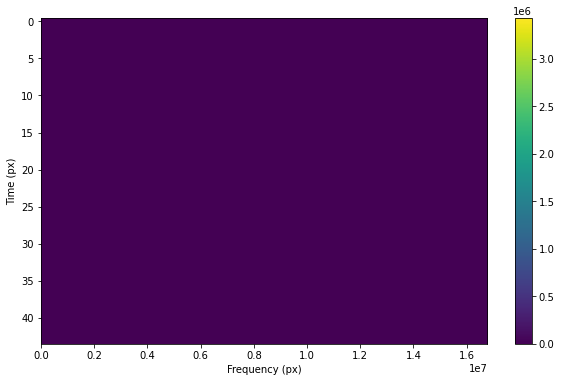

In [7]:
# from astropy import units as u
# import setigen as stg
# import blimpy as bl
# import matplotlib.pyplot as plt

data_path = '/home/eakshay/ea/setigen/data/573_50/inj_573_50.rawspec.0000.fil'
waterfall = bl.Waterfall(data_path)
frame = stg.Frame(waterfall=waterfall)
frame.add_signal(stg.constant_path(f_start=frame.get_frequency(200),
                                   drift_rate=2*u.Hz/u.s),
                 stg.constant_t_profile(level=frame.get_intensity(snr=30)),
                 stg.gaussian_f_profile(width=40*u.Hz),
                 stg.constant_bp_profile(level=1))

fig = plt.figure(figsize=(10, 6))
frame.plot()
plt.show()